# Definition of neuron angle and network phase

In this notebook, we explore the definition of individual neurons angles and network phase in time.

In [1]:
%matplotlib widget
import lotr.plotting as pltltr
import numpy as np
from lotr import A_FISH, FIGURES_LOCATION, LotrExperiment, dataset_folders
from lotr.notebook_utils import print_source
from lotr.pca import pca_and_phase

COLS = pltltr.COLS

from matplotlib import pyplot as plt
from scipy.stats import wilcoxon
from sklearn.decomposition import PCA

fig_location = pltltr.get_nb_figures_location()

## PC over population and network trajectory in phase space

First of all, we load an experiment and we calculate principal components to observe trajectory over time in a reduced number of dimensions.

In [2]:
exp = LotrExperiment(A_FISH)

t_end = 1500  # crop to half experiment for clarity
pca_scores = PCA(n_components=5).fit_transform(
    exp.traces[: t_end * exp.fn, exp.hdn_indexes]
)

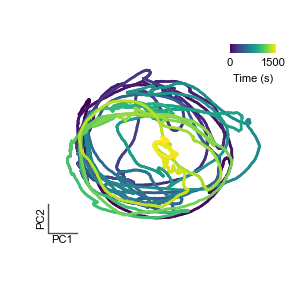

In [4]:
f, ax = plt.subplots(figsize=(3, 3))
s = pltltr.color_plot(
    pca_scores[:, 0],
    pca_scores[:, 1],
    c=np.arange(pca_scores.shape[0]) / exp.fn,
    ax=ax,
    cmap=COLS["time"],
    lw=2,
)
pltltr.add_scalebar(ax, xlabel="PC1", ylabel="PC2", xlen=5, ylen=5)

pltltr.add_cbar(
    s,
    ax,
    inset_loc=(0.85, 0.95, 0.2, 0.04),
    ticks=(0, t_end - 100),
    ticklabels=(0, t_end),
    orientation="horizontal",
    label="Time (s)",
    labelsize=8,
)
ax.axis("equal")
plt.show()

pltltr.savefig(fig_location / "population_trajectory.pdf")

Yay! This looks intriguingly circular! What is happening there?

## PCA over time and neuron angles

If we now look at PCs computed over time, we get a similar circular pattern:

In [6]:
# Find principal components from selected neurons:
pca = PCA(n_components=8).fit(exp.traces[:, exp.hdn_indexes].T)

# Compute scores for all neurons:
pca_scores_t = pca.transform(exp.traces[:, :].T)

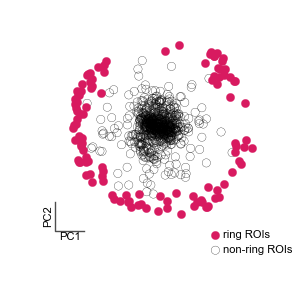

In [7]:
f, ax = plt.subplots(figsize=(3, 3))
s = ax.scatter(
    pca_scores_t[exp.hdn_indexes, 0],
    pca_scores_t[exp.hdn_indexes, 1],
    color=COLS["ring"],
    label="ring ROIs",
    lw=0.2,
)
s = ax.scatter(
    pca_scores_t[exp.nonhdn_indexes, 0],
    pca_scores_t[exp.nonhdn_indexes, 1],
    label="non-ring ROIs",
    fc="none",
    ec="k",
    lw=0.2,
    zorder=-100,
)

plt.legend(
    frameon=False,
    bbox_to_anchor=(1.1, -0.1, 0.04, 0.2),
    markerscale=1,
    handletextpad=-0.3,
    fontsize=8,
)
pltltr.add_scalebar(ax, xlabel="PC1", ylabel="PC2", xlen=30, ylen=30)
ax.axis("equal")
# plt.tight_layout()
plt.subplots_adjust(bottom=0.2)
plt.show()

pltltr.savefig(fig_location / "individual_rois_pcs_cnt.pdf")

This is interesting! How much variability of the data are we reconstructing with those two PCs over which cells are circularly distributed?

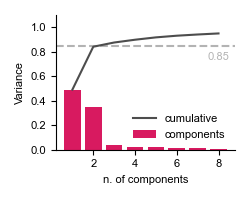

In [8]:
f, ax = plt.subplots(figsize=(2.5, 2.0))
ax.bar(
    np.arange(pca.n_components) + 1,
    pca.explained_variance_ratio_,
    fc=COLS["ring"],
    label="components",
)
ax.plot(
    np.arange(pca.n_components) + 1,
    np.cumsum(pca.explained_variance_ratio_),
    label="cumulative",
    c=(0.3,) * 3,
    zorder=100,
)

l_h = 0.85
ax.axhline(
    l_h, linestyle="dashed", c=(0.7,) * 3,
)
ax.text(8.5, l_h - 0.05, f"{l_h:0.2f}", c=(0.7,) * 3, ha="right", va="top", fontsize=8)
pltltr.despine(ax)
ax.legend()
ax.set(xlabel="n. of components", ylabel="Variance", ylim=(0, 1.1), xticks=[2, 4, 6, 8])
plt.tight_layout()

pltltr.savefig(fig_location / "variance_expl_onefish.pdf")

We can now try to have a look in the full dataset how much variance the first two principal components explain. We will compare this against the distribution of variance explained by first two components in the rest of the dataset.

In [9]:
# Find principal components from selected neurons. The time slice cuts out trace extrema and
# periods of vigorous directional motion in experiments that have it.

all_var_expl_ring = []
all_var_expl_nonring = []
for path in dataset_folders:
    exp = LotrExperiment(path)

    # Loop over data and control:
    for data_list, roi_selection in zip(
        [all_var_expl_ring, all_var_expl_nonring], [exp.hdn_indexes, exp.rndcnt_indexes]
    ):
        pca = PCA(n_components=8).fit(exp.traces[exp.pca_t_slice, roi_selection].T)
        data_list.append(sum(pca.explained_variance_ratio_[:2]))

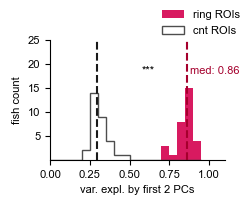

In [11]:
step = 0.05

f, ax = plt.subplots(figsize=(2.5, 2), gridspec_kw=dict(bottom=0.2, left=0.2, top=0.8))

ax.hist(all_var_expl_ring, np.arange(0, 1, step), label="ring ROIs", fc=COLS["ring"])
ax.hist(
    all_var_expl_nonring,
    np.arange(0, 1, step),
    label="cnt ROIs",
    histtype="step",
    ec=".3",
)

medians = []
for values, col in zip([all_var_expl_nonring, all_var_expl_ring], [".3", COLS["ring"]]):
    medians.append(np.median(values))
    ax.axvline(medians[-1], linestyle="dashed", c=pltltr.dark_col(col))

ax.text(
    np.median(medians[-1]) + 0.02,
    18,
    f"med: {medians[-1]:0.2f}",
    c=pltltr.dark_col(col),
    fontsize=8,
)

ax.text(
    min(medians) + abs((medians[0] - medians[1])) / 2,
    18,
    pltltr.get_pval_stars(wilcoxon(all_var_expl_ring, all_var_expl_nonring)),
    fontsize=8,
)


ax.set(
    xlim=(0, 1.1),
    xlabel="var. expl. by first 2 PCs",
    ylabel=("fish count"),
    yticks=(5, 10, 15, 20, 25),
)
# plt.tight_layout()
ax.legend(bbox_to_anchor=(0, 0, 1, 1), bbox_transform=f.transFigure)
pltltr.despine(ax)

plt.show()
pltltr.savefig(fig_location / "pca_var_expl_population.pdf")

## Neuron angles

On these data, it is simple to fit a circle and define for every ROI a "PC angle" as the angle from the center of such circle. 
For $i^{th}$ ROI,

$$ 
{PCangle}_i = arctan(\frac{PC1_i - center_x}{PC2_i - center_y}) 
$$

For this, we use the `pca_and_phase` function:

In [12]:
print_source(pca_and_phase)

In [13]:
# let's get again our example:
exp = LotrExperiment(A_FISH)

pca_scores_t, roi_pc_angles, _, circle_params = pca_and_phase(
    exp.traces[:, exp.hdn_indexes].T
)

# To simplify plotting, we just center the circle on 0:
pca_scores_t[:, :2] = pca_scores_t[:, :2] - circle_params[:2]

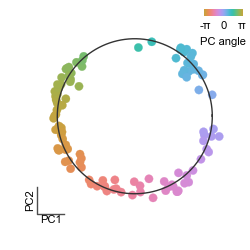

In [16]:
f, ax = plt.subplots(figsize=(2.5, 2.5))
s = ax.scatter(
    pca_scores_t[:, 0],
    pca_scores_t[:, 1],
    c=roi_pc_angles,
    cmap=COLS["phase_light"],
    label="ring ROIs",
    lw=0.2,
)
ax.plot(*pltltr.get_circle_xy((0, 0, circle_params[2])), c=(0.2,) * 3, lw=1)
pltltr.add_scalebar(ax, xlabel="PC1", ylabel="PC2", xlen=30, ylen=30)
ax.axis("equal")

pltltr.add_cbar(
    s,
    ax,
    (0.92, 1.1, 0.2, 0.04),
    ticks=(-np.pi + 0.2, 0, np.pi - 0.2),
    ticklabels=("-π", 0, "π"),
    label="PC angle",
    orientation="horizontal",
)
plt.show()

pltltr.savefig(fig_location / "rois_angles.pdf")

## From neuron angles to network phase

Now, we can start from the fit of neuron angles in PC space to get to a reasonable notion of "phase" in time of the network. At every timepoint, we will take an average vector sum over the neurons of the circle, weighted by the intensity of their fluorescence. At every timepoint, the fluorescence intensity is normalized to have 0 sum. This mean that a neuron can have negative weight and hence negative contribution. Zero-sum normalization help reducing biases that might come from non homogeneous distribution of ROIs along the circle. 

In [17]:
from lotr.rpca_calculation import get_zero_mean_weights
from lotr.utils import get_vect_angle

norm_activity = get_zero_mean_weights(exp.traces[:, exp.hdn_indexes].T).T
avg_vects = np.einsum("ij,ik->jk", norm_activity.T, pca_scores_t[:, :2])

network_phase = get_vect_angle(avg_vects.T)

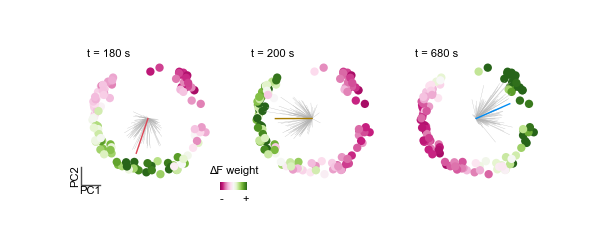

In [20]:
scale_arr = 5000
scale_mn = 60
f_lim = 0.01
f, axs = plt.subplots(1, 3, figsize=(6, 2.5))
for n, (i, ax) in enumerate(zip([900, 1000, 3400], axs)):
    s = ax.scatter(
        pca_scores_t[:, 0],
        pca_scores_t[:, 1],
        c=norm_activity[i, :],
        cmap=COLS["dff_opp"],
        vmin=-f_lim,
        vmax=f_lim,
        lw=0.0,
    )

    for r in range(len(exp.hdn_indexes)):
        angle, length = roi_pc_angles[r], norm_activity[i, r] * scale_arr
        ax.plot(
            [0, np.cos(angle) * length],
            [0, np.sin(angle) * length],
            c=(0.7,) * 3,
            lw=0.2,
        )

    angle, length = network_phase[i], scale_mn
    ax.plot(
        [0, np.cos(angle) * length],
        [0, np.sin(angle) * length],
        c=pltltr.get_default_phase_col(network_phase[i]),
        lw=1,
    )

    # timestamp:
    ax.text(-100, 100, f"t = {i / exp.fn:3.0f} s", fontsize=8)

    if n == 0:
        pltltr.add_scalebar(ax, xlabel="PC1", ylabel="PC2", xlen=30, ylen=30)
        cbar = pltltr.add_cbar(
            s,
            ax,
            (1.1, 0.2, 0.2, 0.04),
            ticks=(-f_lim + 0.001, f_lim - 0.001),
            ticklabels=("-", "+"),
            titlesize=8,
            title="ΔF weight",
            orientation="horizontal",
        )
    else:  # dummy for scaling:
        pltltr.add_scalebar(
            ax, xlabel="", ylabel="", xlen=30, ylen=30, line_params=dict(lw=0)
        )

    ax.axis("equal")

pltltr.savefig(fig_location / "network_phase_explanation.pdf")

In [21]:
from lotr.plotting.gifs_gen.network_phase import network_phase_animation

In [ ]:
# Create animation to explore the concept.
# It won't be displayed inline, and GitHub actions could complay if we try to save mp4, hence the try:
try:
    f = network_phase_animation(fig_location / "network_phase_explained.mp4")
except ValueError:
    pass
# plt.show()

## Network phase and trajectory in phase space

We can now look again at the network trajectory in phase space, to see what is the relationship between the network phase defined above and positions in phase space.

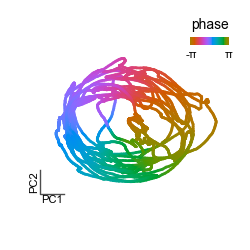

In [22]:
f, ax = plt.subplots(figsize=(2.5, 2.5))
s = pltltr.color_plot(
    pca_scores[:, 0],
    pca_scores[:, 1],
    c=network_phase[: t_end * exp.fn],
    ax=ax,
    cmap=COLS["phase"],
    lw=2,
)
pltltr.add_scalebar(ax, xlabel="PC1", ylabel="PC2", xlen=5, ylen=5)

pltltr.add_phase_cbar(
    s, ax, inset_loc=(0.85, 0.95, 0.2, 0.04), orientation="horizontal",
)
ax.axis("equal")
plt.show()

pltltr.savefig(fig_location / "population_trajectory_with_phase.pdf")

Cool! It seems that our definition of phase really captures what is happening in this trajectory.

It would be very cool to see whether this organization is linked to anatomical disposition of cells. This will be analyzed in the next notebook.